## Install Packages

In [ ]:
#Install packages
install.packages(c("tidyr", "dplyr","ggplot2", "scales", "ordinal","emmeans","broom","writexl","readxl", "openxlsx", "reshape2"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ucminf’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘plyr’




# 1. Collapsed Data

## Read Data

In [ ]:
#This is the data that shows judgements for the survey
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresfile.csv")

## Crosstab View

In [ ]:
# Create cross-tabulation
cross_tab <- table(df$Question, df$Scores)

# Print the cross-tabulation
print(cross_tab)

# Convert to dataframe if needed
cross_tab_df <- as.data.frame(cross_tab)

# Optionally, add row and column totals
cross_tab_with_margins <- addmargins(cross_tab)

# Optionally, format the table
formatted_table <- ftable(cross_tab)


       
          1   2   3   4   5
  OIRA   23 167  99 464 232
  OIRAB 188 230 497  70   0
  OIRB   22 146  99 464 254
  OIRBB 161 435 341  48   0
  RFCA   69 106  92 244 474
  RFCB  169 406 131 231  48
  RFCC  122 268 164 309 122
  RFCD  150 298 204 239  94


## Data Visualization

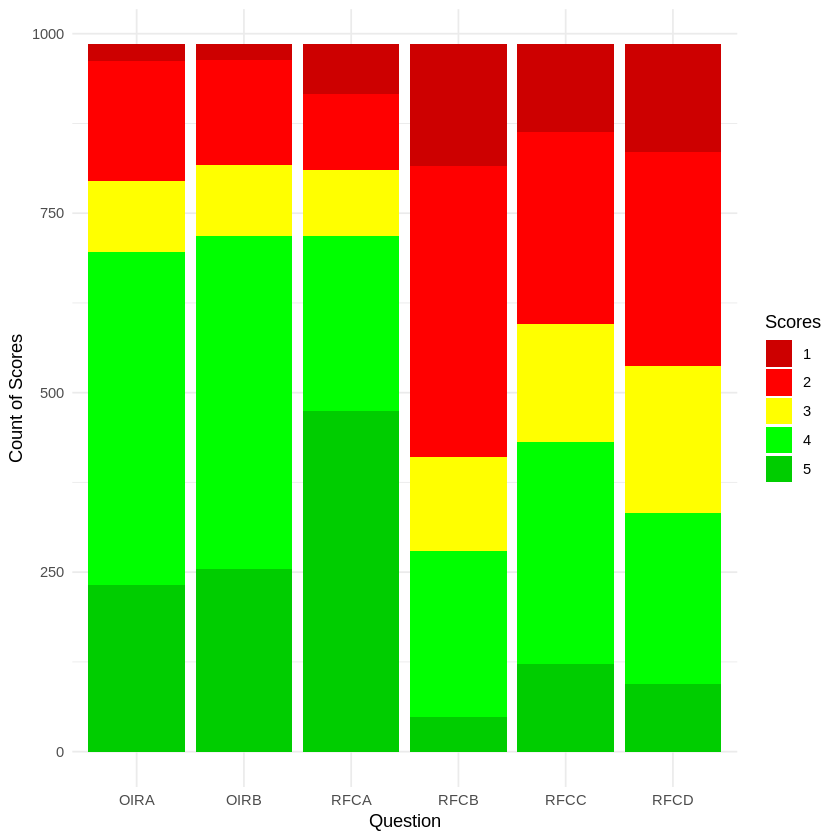

In [ ]:
library(ggplot2)
library(dplyr)

# Assuming your data frame is named "df"
df$Scores <- factor(df$Scores)

# Filter out rows for specific questions
df_filtered <- df %>%
  filter(Question != "OIRAB" & Question != "OIRBB")

# Create a custom pastel color palette
custom_palette <- c("red3", "red", "yellow", "green", "green3")


ggplot(df_filtered, aes(x = Question, fill = Scores)) +
  geom_bar(position = "stack") +
  scale_fill_manual(values = custom_palette) +
  labs(x = "Question", y = "Count of Scores") +
  theme_minimal()


## Ordinal Regression

In [ ]:
library(ordinal)
library(broom)
library(writexl)

# Convert Likert to factor
df$Question <- factor(df$Question)
df$Scores <- factor(df$Scores)

# Fit an ordinal regression model
model <- clm(Scores ~ DEM2 + EXP1 + EXP1A + EXP2 + EXP3 + Question, data = df)

# Extract coefficients and related information
coefficients_df <- tidy(model)

# Extract Odds Ratios and Confidence Intervals
odds_ratio <- exp(coef(model))
conf_intervals <- exp(confint.default(model))

# Create a dataframe
effect <- rownames(coefficients_df)
coefficient <- coefficients_df$estimate
std_error <- coefficients_df$std.error
z_value <- coefficients_df$statistic
p_value <- coefficients_df$p.value
odds_ratio_val <- odds_ratio
ci_lower <- conf_intervals[, "2.5 %"]
ci_upper <- conf_intervals[, "97.5 %"]

# Combine into a dataframe
result_df <- data.frame(
  Effect = effect,
  Coefficient = round(coefficient, 2),
  `Std. Error` = round(std_error, 2),
  `Z Value` = round(z_value, 2),
  `P Value` = ifelse(p_value < 0.001, "<0.001***", ifelse(p_value < 0.01, "<0.01**", ifelse(p_value < 0.05, "<0.05*", round(p_value, 2)))),
  `Odds Ratio` = round(odds_ratio_val, 2),
  `CI Lower` = round(ci_lower, 2),
  `CI Upper` = round(ci_upper, 2)
)

# Extract main effects coefficients and related information
main_effects <- coefficients_df[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", coefficients_df$term) & !grepl(":", coefficients_df$term), ]

# Extract main effects Odds Ratios and Confidence Intervals
main_odds_ratio <- exp(coef(model)[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", names(coef(model))) & !grepl(":", names(coef(model)))])
main_conf_intervals <- exp(confint.default(model)[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", names(coef(model))) & !grepl(":", names(coef(model))), ])

# Create a dataframe for main effects
main_effects_df <- data.frame(
  Effect = main_effects$term,
  Coefficient = round(main_effects$estimate, 2),
  `Std. Error` = round(main_effects$std.error, 2),
  `Z Value` = round(main_effects$statistic, 2),
  `P Value` = ifelse(main_effects$p.value < 0.001, "<0.001***", ifelse(main_effects$p.value < 0.01, "<0.01**", ifelse(main_effects$p.value < 0.05, "<0.05*", round(main_effects$p.value, 2)))),
  `Odds Ratio` = round(main_odds_ratio, 2),
  `CI Lower` = round(main_conf_intervals[, "2.5 %"], 2),
  `CI Upper` = round(main_conf_intervals[, "97.5 %"], 2)
)


# Order main effects dataframe by Coefficient in descending order
main_effects_df <- main_effects_df[order(-main_effects_df$Coefficient), ]

# Print the modified main effects dataframe
print("Main Effects:")
print(main_effects_df)

# Write main_effects_df to a CSV file
write.csv(main_effects_df, file = "main_effects_output.csv", row.names = FALSE)

# Confirm completion
cat("Main effects dataframe written to 'main_effects_output.csv' successfully!\n")


[1] "Main Effects:"
                                                                                                         Effect
QuestionRFCA                                                                                       QuestionRFCA
DEM245-54 years old                                                                         DEM245-54 years old
DEM255-64 years old                                                                         DEM255-64 years old
DEM235-44 years old                                                                         DEM235-44 years old
DEM225-34 years old                                                                         DEM225-34 years old
EXP1Yes                                                                                                 EXP1Yes
EXP3Yes                                                                                                 EXP3Yes
QuestionOIRB                                                                        

# 2. Uncollapsed Data

## Read Data

In [ ]:
#This is the data that shows judgements for the survey
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresnoncondensedlong.csv")

## OIR

### Crosstab View

In [ ]:
# Filter out rows for specific questions

# Define the list of questions you want to include
included_questions <- c("OIRA1A", "OIRA2A", "OIRA3A", "OIRA4A", "OIRA5A",
                        "OIRB1A", "OIRB2A", "OIRB3A", "OIRB4A", "OIRB5A")

# Filter the original dataframe to include only the specified questions
df_filtered_OIR <- df[df$Question %in% included_questions, ]

# Create cross-tabulation
cross_tab <- table(df_filtered_OIR$Question, df_filtered_OIR$Scores)

# Print the cross-tabulation
print(cross_tab)

# Convert to dataframe if needed
cross_tab_df <- as.data.frame(cross_tab)

# Optionally, add row and column totals
cross_tab_with_margins <- addmargins(cross_tab)

# Optionally, format the table
formatted_table <- ftable(cross_tab)


        
           1   2   3   4   5
  OIRA1A   7  31   9  85  65
  OIRA2A   4  34  28  89  42
  OIRA3A   2  37  20 104  34
  OIRA4A   5  20  17  96  59
  OIRA5A   5  45  25  90  32
  OIRB1A   2  27  11  82  75
  OIRB2A   4  24  18 102  49
  OIRB3A   2  33  24  99  39
  OIRB4A   3  20  18  94  62
  OIRB5A  11  42  28  87  29


### Data Visualization

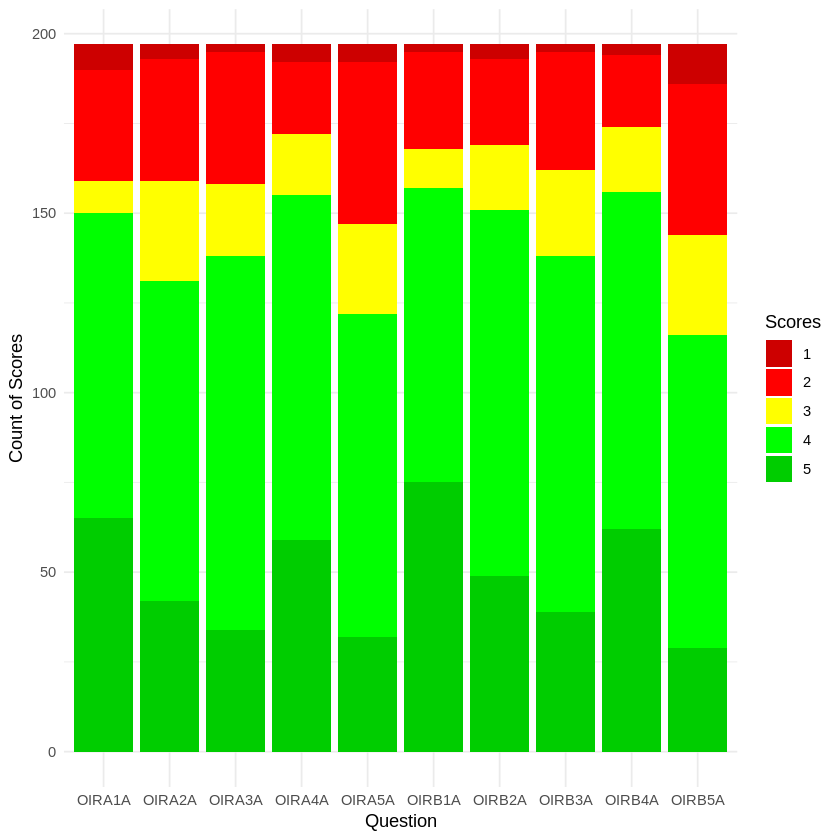

In [ ]:
library(ggplot2)
library(dplyr)

df$Scores <- factor(df$Scores)

# Filter out rows for specific questions
df_filtered_OIR <- df %>%
  filter(Question %in% c("OIRA1A", "OIRA2A", "OIRA3A", "OIRA4A", "OIRA5A", "OIRB1A", "OIRB2A", "OIRB3A", "OIRB4A", "OIRB5A"))

# Create a custom pastel color palette
custom_palette <- c("red3", "red", "yellow", "green", "green3")

ggplot(df_filtered_OIR, aes(x = Question, fill = Scores)) +
  geom_bar(position = "stack") +
  scale_fill_manual(values = custom_palette) +
  labs(x = "Question", y = "Count of Scores") +
  theme_minimal()


# Set the width and height of the plot
ggsave("OIR.png", width = 20, height = 6)


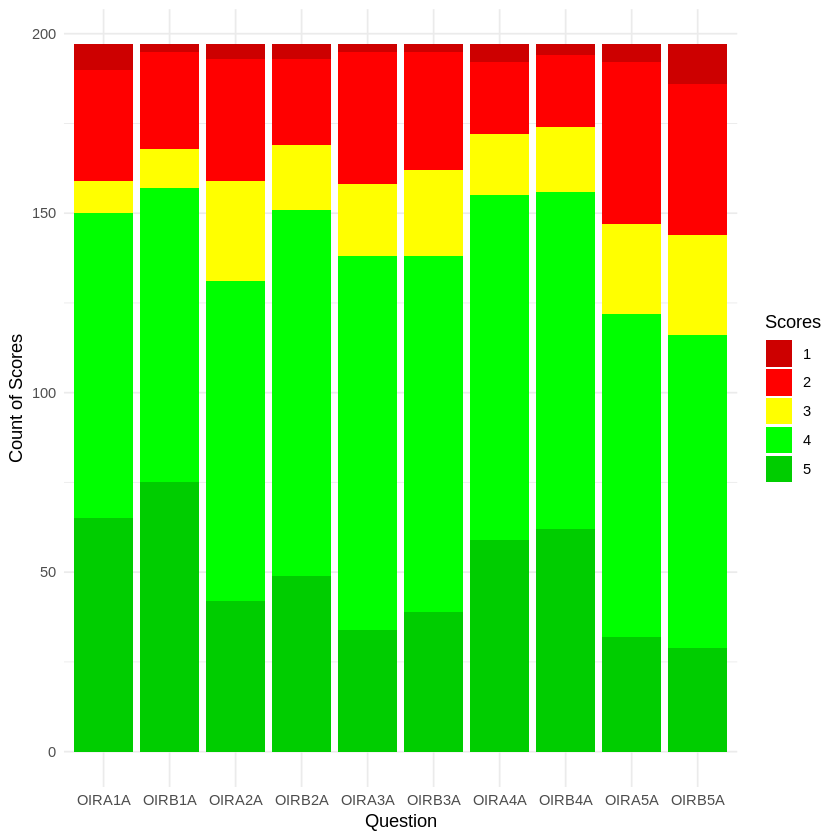

In [ ]:
library(ggplot2)
library(dplyr)

# Assuming df is your dataframe containing Question and Scores columns
df$Scores <- factor(df$Scores)

# Filter out rows for specific questions
df_filtered_OIR <- df %>%
  filter(Question %in% c("OIRA1A", "OIRA2A", "OIRA3A", "OIRA4A", "OIRA5A", "OIRB1A", "OIRB2A", "OIRB3A", "OIRB4A", "OIRB5A"))

# Define the order of questions
question_order <- c("OIRA1A", "OIRB1A", "OIRA2A", "OIRB2A", "OIRA3A", "OIRB3A", "OIRA4A", "OIRB4A", "OIRA5A", "OIRB5A")

# Reorder the Question column based on the defined order
df_filtered_OIR$Question <- factor(df_filtered_OIR$Question, levels = question_order)

# Create a custom pastel color palette
custom_palette <- c("red3", "red", "yellow", "green", "green3")

# Plot the data
ggplot(df_filtered_OIR, aes(x = Question, fill = Scores)) +
  geom_bar(position = "stack") +
  scale_fill_manual(values = custom_palette) +
  labs(x = "Question", y = "Count of Scores") +
  theme_minimal()

# Set the width and height of the plot
ggsave("OIR.png", width = 20, height = 6)

### Ordinal Regression

In [ ]:
library(ordinal)
library(broom)
library(writexl)

# Convert Likert to factor
df$Question <- factor(df$Question)
df$Scores <- factor(df$Scores)


# Fit an ordinal regression model
model <- clm(Scores ~ Question, data = df_filtered_OIR)


# Extract coefficients and related information
coefficients_df <- tidy(model)

# Extract Odds Ratios and Confidence Intervals
odds_ratio <- exp(coef(model))
conf_intervals <- exp(confint.default(model))

# Create a dataframe
effect <- rownames(coefficients_df)
coefficient <- coefficients_df$estimate
std_error <- coefficients_df$std.error
z_value <- coefficients_df$statistic
p_value <- coefficients_df$p.value
odds_ratio_val <- odds_ratio
ci_lower <- conf_intervals[, "2.5 %"]
ci_upper <- conf_intervals[, "97.5 %"]

# Combine into a dataframe
result_df <- data.frame(
  Effect = effect,
  Coefficient = round(coefficient, 2),
  `Std. Error` = round(std_error, 2),
  `Z Value` = round(z_value, 2),
  `P Value` = ifelse(p_value < 0.001, "<0.001***", ifelse(p_value < 0.01, "<0.01**", ifelse(p_value < 0.05, "<0.05*", round(p_value, 2)))),
  `Odds Ratio` = round(odds_ratio_val, 2),
  `CI Lower` = round(ci_lower, 2),
  `CI Upper` = round(ci_upper, 2)
)

# Extract main effects coefficients and related information
main_effects <- coefficients_df[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", coefficients_df$term) & !grepl(":", coefficients_df$term), ]

# Extract main effects Odds Ratios and Confidence Intervals
main_odds_ratio <- exp(coef(model)[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", names(coef(model))) & !grepl(":", names(coef(model)))])
main_conf_intervals <- exp(confint.default(model)[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", names(coef(model))) & !grepl(":", names(coef(model))), ])

# Create a dataframe for main effects
main_effects_df <- data.frame(
  Effect = main_effects$term,
  Coefficient = round(main_effects$estimate, 2),
  `Std. Error` = round(main_effects$std.error, 2),
  `Z Value` = round(main_effects$statistic, 2),
  `P Value` = ifelse(main_effects$p.value < 0.001, "<0.001***", ifelse(main_effects$p.value < 0.01, "<0.01**", ifelse(main_effects$p.value < 0.05, "<0.05*", round(main_effects$p.value, 2)))),
  `Odds Ratio` = round(main_odds_ratio, 2),
  `CI Lower` = round(main_conf_intervals[, "2.5 %"], 2),
  `CI Upper` = round(main_conf_intervals[, "97.5 %"], 2)
)


# Order main effects dataframe by Coefficient in descending order
main_effects_df <- main_effects_df[order(-main_effects_df$Coefficient), ]

# Print the modified main effects dataframe
print("Main Effects:")
print(main_effects_df)

# Write main_effects_df to a CSV file
write.csv(main_effects_df, file = "main_effects_uncondensed_output.csv", row.names = FALSE)

# Confirm completion
cat("Main effects dataframe written to 'main_effects_output.csv' successfully!\n")


[1] "Main Effects:"
                       Effect Coefficient Std..Error Z.Value   P.Value
QuestionOIRB1A QuestionOIRB1A        0.27       0.19    1.37      0.17
QuestionOIRB4A QuestionOIRB4A        0.08       0.19    0.43      0.67
QuestionOIRA4A QuestionOIRA4A        0.02       0.19    0.10      0.92
QuestionOIRB2A QuestionOIRB2A       -0.16       0.19   -0.86      0.39
QuestionOIRB3A QuestionOIRB3A       -0.44       0.19   -2.33    <0.05*
QuestionOIRA2A QuestionOIRA2A       -0.50       0.19   -2.61   <0.01**
QuestionOIRA3A QuestionOIRA3A       -0.52       0.19   -2.74   <0.01**
QuestionOIRA5A QuestionOIRA5A       -0.77       0.19   -4.04 <0.001***
QuestionOIRB5A QuestionOIRB5A       -0.91       0.19   -4.74 <0.001***
               Odds.Ratio CI.Lower CI.Upper
QuestionOIRB1A       1.30     0.89     1.91
QuestionOIRB4A       1.09     0.75     1.58
QuestionOIRA4A       1.02     0.70     1.48
QuestionOIRB2A       0.85     0.58     1.23
QuestionOIRB3A       0.64     0.44     0.93
Questi

In [ ]:
library(emmeans)

# Fit the Ordinal Regression Model
o <- clm(Scores ~ Question, data = df_filtered_OIR)

# Calculate Estimated Marginal Means for Strategy variable

emm_strategy <- emmeans(o, pairwise ~ Question)

# Extract the results
results <- summary(emm_strategy, adjust = "holm")

# Convert the contrasts table to a dataframe
df_contrasts <- as.data.frame(results$contrasts)

# Create a function to format P values
format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

# Create dataframe for pairwise comparisons
df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2),
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)
)

# Print the new pairwise dataframe
print(df_pairwise)

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



            Effect Coefficient Std..Error Z.Value   P.Value Odds_Ratio CI_Lower
1  OIRA1A - OIRB1A       -0.27       0.19   -1.37         1       0.77     0.52
2  OIRA1A - OIRA2A        0.50       0.19    2.61    0.2357       1.64     1.13
3  OIRA1A - OIRB2A        0.16       0.19    0.86         1       1.18     0.81
4  OIRA1A - OIRA3A        0.52       0.19    2.74    0.1669       1.68     1.16
5  OIRA1A - OIRB3A        0.44       0.19    2.33     0.459       1.55     1.07
6  OIRA1A - OIRA4A       -0.02       0.19   -0.10         1       0.98     0.67
7  OIRA1A - OIRB4A       -0.08       0.19   -0.43         1       0.92     0.63
8  OIRA1A - OIRA5A        0.77       0.19    4.04   <0.01**       2.16     1.49
9  OIRA1A - OIRB5A        0.91       0.19    4.74 <0.001***       2.47     1.70
10 OIRB1A - OIRA2A        0.76       0.19    4.01   <0.01**       2.14     1.48
11 OIRB1A - OIRB2A        0.43       0.19    2.26    0.5232       1.54     1.06
12 OIRB1A - OIRA3A        0.78       0.1

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `legend.title.align` argument of `theme()` is deprecated as of ggplot2
3.5.0.
ℹ Please use theme(legend.title = element_text(hjust)) instead.”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Times New Roman' not found in PostScript font database”
W

ERROR: Error in loadNamespace(x): there is no package called ‘svglite’


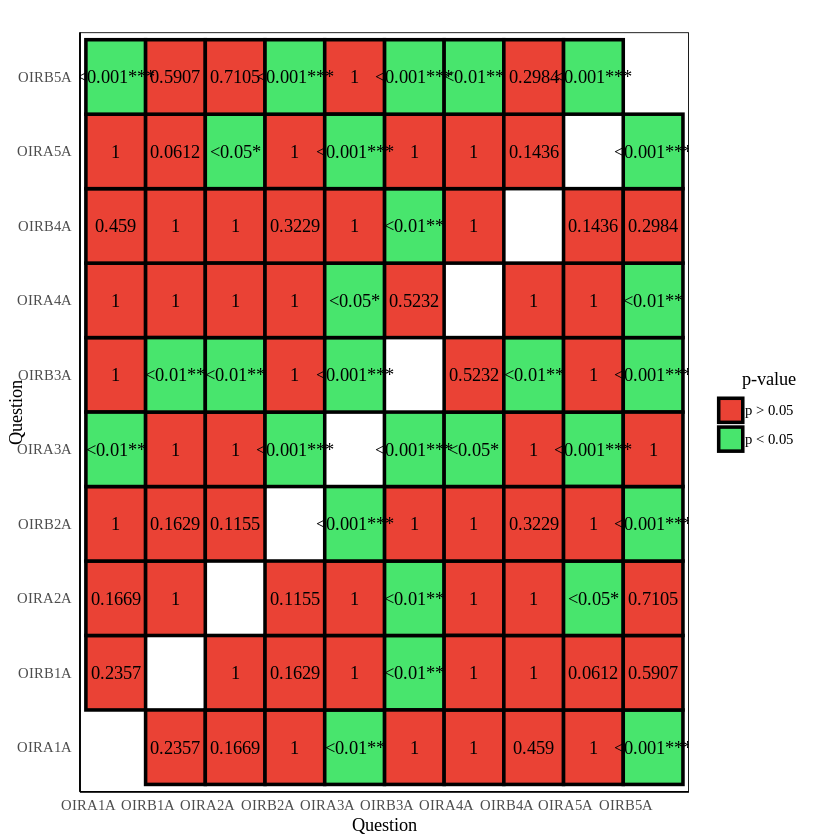

In [ ]:
# Load necessary libraries
library(ggplot2)
library(scales)

# Convert Effect column to factors with the desired order
df_contrasts <- transform(df_pairwise,
                          x = as.character(sapply(strsplit(as.character(Effect), " - "), "[[", 1)),
                          y = as.character(sapply(strsplit(as.character(Effect), " - "), "[[", 2)))


# Get unique values from both x and y columns
all_effects <- unique(c(df_contrasts$x, df_contrasts$y))

# Reordering columns
df_contrasts <- df_contrasts[, c("x", "y", "P.Value")]

# Create mirrored data
df_mirrored <- rbind(df_contrasts, transform(df_contrasts, x = y, y = x))

# Create function to format p-values
format_pvalue <- function(pvalue) {
  if (is.numeric(pvalue)) {
    ifelse(pvalue < 0.001, "<0.001",
           ifelse(pvalue < 0.01, "<0.01",
                  ifelse(pvalue < 0.05, "<0.05", sprintf("%.2f", pvalue))))
  } else {
    pvalue
  }
}

# Create heatmap with borders and a distinct color palette
plot <- ggplot(df_mirrored, aes(x = x, y = y, fill = P.Value < 0.05)) +
  geom_tile(color = "black", size = 1) +  # Add borders around cells
  geom_text(aes(label = format_pvalue(P.Value)), vjust = 0.5, hjust = 0.5, color = "black", family = "Times New Roman") +  # Center text
  scale_fill_manual(values = c("#EA4235", "#48E56D"), labels = c("p > 0.05", "p < 0.05"), name = "p-value") +  # Assign colors and labels
  labs(x = "Question",
       y = "Question",
       fill = NULL,
       title = " ") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 0, hjust = 1, family = "Times New Roman"),  # Adjust font size for x axis labels
        axis.text.y = element_text(family = "Times New Roman"),  # Adjust font size for y axis labels
        axis.title.x = element_text(family = "Times New Roman"),  # Adjust font size for x axis title
        axis.title.y = element_text(family = "Times New Roman"),  # Adjust font size for y axis title
        legend.title = element_text(family = "Times New Roman", hjust = 0.5),  # Set legend title font and center it
        legend.title.align = 0.5,  # Center the legend title
        legend.text = element_text(family = "Times New Roman", margin = margin(0, 10, 0, 0)),  # Adjust legend text size and margin
        panel.grid = element_blank(),  # Remove grid lines
        panel.border = element_rect(color = "black", fill = NA),  # Add border around plot
        axis.line = element_line(color = "black"),
        plot.title = element_text(hjust = 0.5, family = "Times New Roman"),
        plot.caption = element_text(hjust = 0.5, family = "Times New Roman")) +  # Center the title
  scale_x_discrete(labels = all_effects) +
  scale_y_discrete(labels = all_effects)

# Save the plot as a scalable vector graphic (SVG) with higher resolution
plot
ggsave("HeatmapOIR.svg", plot, width = 10, height = 6, dpi = 300)

## RFC

### Crosstab View

In [ ]:
# Define the list of questions you want to include
included_questions <- c("RFCA1A", "RFCA2A", "RFCA3A", "RFCA4A", "RFCA5A",
                         "RFCB1A", "RFCB2A", "RFCB3A", "RFCB4A", "RFCB5A",
                         "RFCC1A", "RFCC2A", "RFCC3A", "RFCC4A", "RFCC5A",
                         "RFCD1A", "RFCD2A", "RFCD3A", "RFCD4A", "RFCD5A")

# Filter the original dataframe to include only the specified questions
df_filtered_RFC <- df[df$Question %in% included_questions, ]

# Create cross-tabulation
cross_tab <- table(df_filtered_RFC$Question, df_filtered_RFC$Scores)

# Print the cross-tabulation
print(cross_tab)

# Convert to dataframe if needed
cross_tab_df <- as.data.frame(cross_tab)

# Optionally, add row and column totals
cross_tab_with_margins <- addmargins(cross_tab)

# Optionally, format the table
formatted_table <- ftable(cross_tab)


        
           0   1   2   3   4   5
  DEM2     0   0   0   0   0   0
  EXP1     0   0   0   0   0   0
  EXP1A    0   0   0   0   0   0
  EXP2     0   0   0   0   0   0
  EXP3     0   0   0   0   0   0
  OIRA1A   0   0   0   0   0   0
  OIRA1B   0   0   0   0   0   0
  OIRA2A   0   0   0   0   0   0
  OIRA2B   0   0   0   0   0   0
  OIRA3A   0   0   0   0   0   0
  OIRA3B   0   0   0   0   0   0
  OIRA4A   0   0   0   0   0   0
  OIRA4B   0   0   0   0   0   0
  OIRA5A   0   0   0   0   0   0
  OIRA5B   0   0   0   0   0   0
  OIRB1A   0   0   0   0   0   0
  OIRB1B   0   0   0   0   0   0
  OIRB2A   0   0   0   0   0   0
  OIRB2B   0   0   0   0   0   0
  OIRB3A   0   0   0   0   0   0
  OIRB3B   0   0   0   0   0   0
  OIRB4A   0   0   0   0   0   0
  OIRB4B   0   0   0   0   0   0
  OIRB5A   0   0   0   0   0   0
  OIRB5B   0   0   0   0   0   0
  RFCA1A   0  32  41  22  42  60
  RFCA2A   0  17  31  42  66  41
  RFCA3A   0   7  11   7  45 127
  RFCA4A   0   5  13  12  53 114
 

### Data Visualization

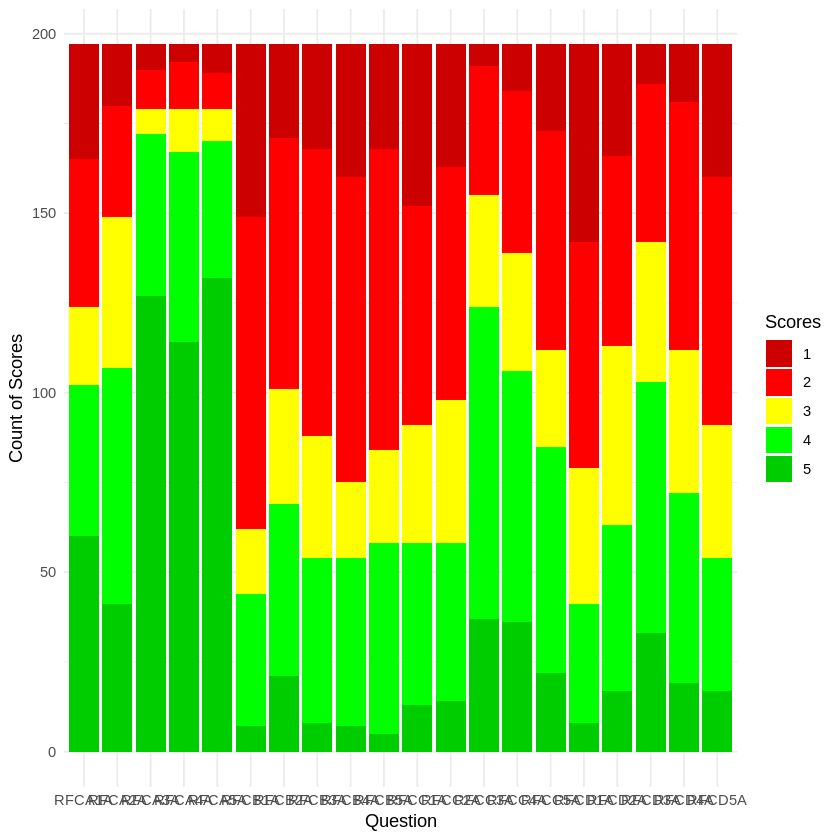

In [ ]:
library(ggplot2)
library(dplyr)

df$Scores <- factor(df$Scores)

# Filter out rows for specific questions
df_filtered_RFC <- df %>%
  filter(Question %in% c("RFCA1A", "RFCA2A", "RFCA3A", "RFCA4A", "RFCA5A",
                         "RFCB1A", "RFCB2A", "RFCB3A", "RFCB4A", "RFCB5A",
                         "RFCC1A", "RFCC2A", "RFCC3A", "RFCC4A", "RFCC5A",
                         "RFCD1A", "RFCD2A", "RFCD3A", "RFCD4A", "RFCD5A"))

# Create a custom pastel color palette
custom_palette <- c("red3", "red", "yellow", "green", "green3")

p <- ggplot(df_filtered_RFC, aes(x = Question, fill = Scores)) +
  geom_bar(position = "stack") +
  scale_fill_manual(values = custom_palette) +
  labs(x = "Question", y = "Count of Scores") +
  theme_minimal()

p

# Set the width and height of the plot
ggsave("RFC.png", plot = p, width = 20, height = 6)


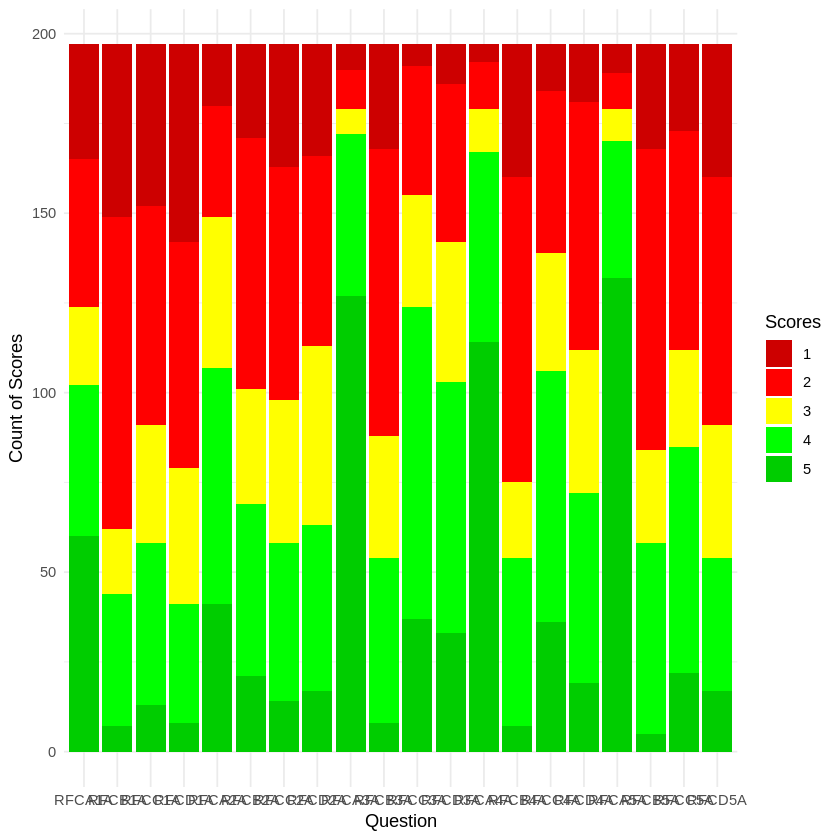

In [ ]:
library(ggplot2)
library(dplyr)

# Define the desired order for the x-axis
order_sequence <- c("RFCA1A", "RFCB1A", "RFCC1A", "RFCD1A",
                    "RFCA2A", "RFCB2A", "RFCC2A", "RFCD2A",
                    "RFCA3A", "RFCB3A", "RFCC3A", "RFCD3A",
                    "RFCA4A", "RFCB4A", "RFCC4A", "RFCD4A",
                    "RFCA5A", "RFCB5A", "RFCC5A", "RFCD5A")

# Convert "Question" to factor with specified levels
df$Question <- factor(df$Question, levels = order_sequence)

# Filter out rows for specific questions
df_filtered_RFC <- df %>%
  filter(Question %in% c("RFCA1A", "RFCB1A", "RFCC1A", "RFCD1A",
                         "RFCA2A", "RFCB2A", "RFCC2A", "RFCD2A",
                         "RFCA3A", "RFCB3A", "RFCC3A", "RFCD3A",
                         "RFCA4A", "RFCB4A", "RFCC4A", "RFCD4A",
                         "RFCA5A", "RFCB5A", "RFCC5A", "RFCD5A"))

# Create a custom pastel color palette
custom_palette <- c("red3", "red", "yellow", "green", "green3")

p <- ggplot(df_filtered_RFC, aes(x = Question, fill = Scores)) +
  geom_bar(position = "stack") +
  scale_fill_manual(values = custom_palette) +
  labs(x = "Question", y = "Count of Scores") +
  theme_minimal()

p

# Set the width and height of the plot
ggsave("RFC.png", plot = p, width = 20, height = 6)


### Ordinal Regression

In [ ]:
library(ordinal)
library(broom)
library(writexl)

# Convert Likert to factor
df$Question <- factor(df$Question)
df$Scores <- factor(df$Scores)


# Fit an ordinal regression model
model <- clm(Scores ~ Question, data = df_filtered_RFC)


# Extract coefficients and related information
coefficients_df <- tidy(model)

# Extract Odds Ratios and Confidence Intervals
odds_ratio <- exp(coef(model))
conf_intervals <- exp(confint.default(model))

# Create a dataframe
effect <- rownames(coefficients_df)
coefficient <- coefficients_df$estimate
std_error <- coefficients_df$std.error
z_value <- coefficients_df$statistic
p_value <- coefficients_df$p.value
odds_ratio_val <- odds_ratio
ci_lower <- conf_intervals[, "2.5 %"]
ci_upper <- conf_intervals[, "97.5 %"]

# Combine into a dataframe
result_df <- data.frame(
  Effect = effect,
  Coefficient = round(coefficient, 2),
  `Std. Error` = round(std_error, 2),
  `Z Value` = round(z_value, 2),
  `P Value` = ifelse(p_value < 0.001, "<0.001***", ifelse(p_value < 0.01, "<0.01**", ifelse(p_value < 0.05, "<0.05*", round(p_value, 2)))),
  `Odds Ratio` = round(odds_ratio_val, 2),
  `CI Lower` = round(ci_lower, 2),
  `CI Upper` = round(ci_upper, 2)
)

# Extract main effects coefficients and related information
main_effects <- coefficients_df[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", coefficients_df$term) & !grepl(":", coefficients_df$term), ]

# Extract main effects Odds Ratios and Confidence Intervals
main_odds_ratio <- exp(coef(model)[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", names(coef(model))) & !grepl(":", names(coef(model)))])
main_conf_intervals <- exp(confint.default(model)[grepl("DEM2|EXP1|EXP1A|EXP2|EXP3|Question", names(coef(model))) & !grepl(":", names(coef(model))), ])

# Create a dataframe for main effects
main_effects_df <- data.frame(
  Effect = main_effects$term,
  Coefficient = round(main_effects$estimate, 2),
  `Std. Error` = round(main_effects$std.error, 2),
  `Z Value` = round(main_effects$statistic, 2),
  `P Value` = ifelse(main_effects$p.value < 0.001, "<0.001***", ifelse(main_effects$p.value < 0.01, "<0.01**", ifelse(main_effects$p.value < 0.05, "<0.05*", round(main_effects$p.value, 2)))),
  `Odds Ratio` = round(main_odds_ratio, 2),
  `CI Lower` = round(main_conf_intervals[, "2.5 %"], 2),
  `CI Upper` = round(main_conf_intervals[, "97.5 %"], 2)
)


# Order main effects dataframe by Coefficient in descending order
main_effects_df <- main_effects_df[order(-main_effects_df$Coefficient), ]

# Print the modified main effects dataframe
print("Main Effects:")
print(main_effects_df)

# Write main_effects_df to a CSV file
write.csv(main_effects_df, file = "main_effects_uncondensed_output.csv", row.names = FALSE)

# Confirm completion
cat("Main effects dataframe written to 'main_effects_output.csv' successfully!\n")


[1] "Main Effects:"
                       Effect Coefficient Std..Error Z.Value   P.Value
QuestionRFCA5A QuestionRFCA5A        2.10       0.21   10.02 <0.001***
QuestionRFCA3A QuestionRFCA3A        2.01       0.21    9.74 <0.001***
QuestionRFCA4A QuestionRFCA4A        1.74       0.20    8.64 <0.001***
QuestionRFCC3A QuestionRFCC3A        0.29       0.19    1.54      0.12
QuestionRFCA2A QuestionRFCA2A        0.11       0.19    0.57      0.57
QuestionRFCC4A QuestionRFCC4A        0.01       0.19    0.06      0.95
QuestionRFCD3A QuestionRFCD3A       -0.01       0.19   -0.05      0.96
QuestionRFCC5A QuestionRFCC5A       -0.52       0.19   -2.71   <0.01**
QuestionRFCD4A QuestionRFCD4A       -0.58       0.19   -3.07   <0.01**
QuestionRFCB2A QuestionRFCB2A       -0.74       0.19   -3.89 <0.001***
QuestionRFCD2A QuestionRFCD2A       -0.75       0.19   -3.95 <0.001***
QuestionRFCC2A QuestionRFCC2A       -0.94       0.19   -4.95 <0.001***
QuestionRFCB3A QuestionRFCB3A       -1.04       0.19   -5

In [ ]:
library(emmeans)

# Fit the Ordinal Regression Model
o <- clm(Scores ~ Question, data = df_filtered_RFC)

# Calculate Estimated Marginal Means for Strategy variable

emm_strategy <- emmeans(o, pairwise ~ Question)

# Extract the results
results <- summary(emm_strategy, adjust = "holm")

# Convert the contrasts table to a dataframe
df_contrasts <- as.data.frame(results$contrasts)

# Create a function to format P values
format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

# Create dataframe for pairwise comparisons
df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2),
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)
)

# Print the new pairwise dataframe
print(df_pairwise)

             Effect Coefficient Std..Error Z.Value   P.Value Odds_Ratio
1   RFCA1A - RFCB1A        1.50       0.19    7.77 <0.001***       4.46
2   RFCA1A - RFCC1A        1.11       0.19    5.73 <0.001***       3.02
3   RFCA1A - RFCD1A        1.43       0.19    7.41 <0.001***       4.19
4   RFCA1A - RFCA2A       -0.11       0.19   -0.57         1       0.90
5   RFCA1A - RFCB2A        0.74       0.19    3.89   <0.01**       2.10
6   RFCA1A - RFCC2A        0.94       0.19    4.95 <0.001***       2.57
7   RFCA1A - RFCD2A        0.75       0.19    3.95   <0.01**       2.11
8   RFCA1A - RFCA3A       -2.01       0.21   -9.74 <0.001***       0.13
9   RFCA1A - RFCB3A        1.04       0.19    5.47 <0.001***       2.82
10  RFCA1A - RFCC3A       -0.29       0.19   -1.54         1       0.75
11  RFCA1A - RFCD3A        0.01       0.19    0.05         1       1.01
12  RFCA1A - RFCA4A       -1.74       0.20   -8.64 <0.001***       0.18
13  RFCA1A - RFCB4A        1.22       0.19    6.38 <0.001***    

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Times New Roman' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font 

ERROR: Error in loadNamespace(x): there is no package called ‘svglite’


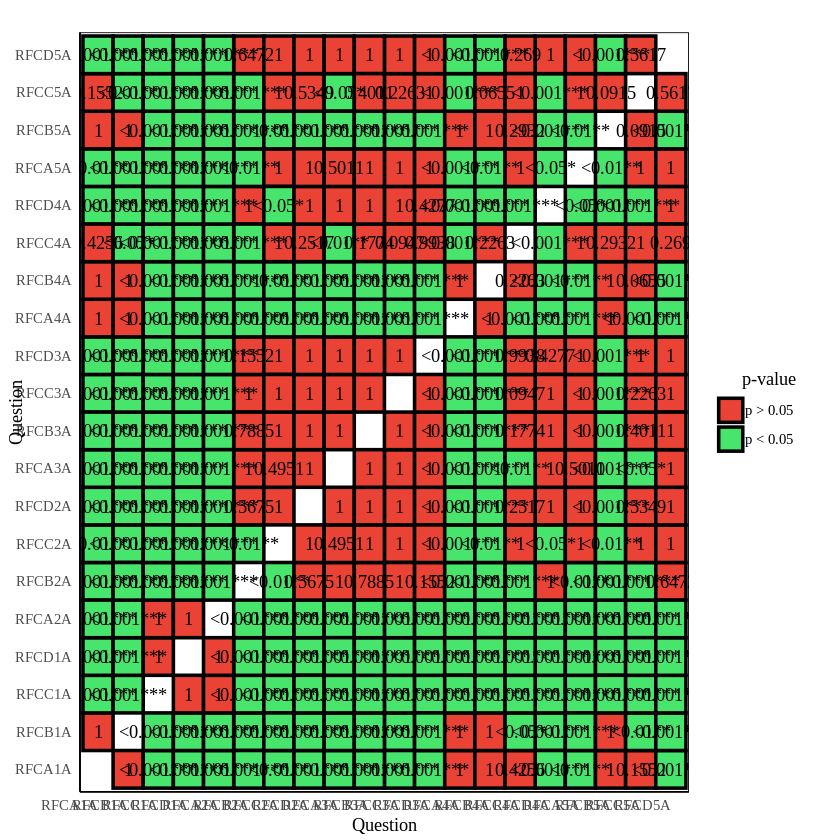

In [ ]:
# Load necessary libraries
library(ggplot2)
library(scales)

# Convert Effect column to factors with the desired order
df_contrasts <- transform(df_pairwise,
                          x = as.character(sapply(strsplit(as.character(Effect), " - "), "[[", 1)),
                          y = as.character(sapply(strsplit(as.character(Effect), " - "), "[[", 2)))


# Get unique values from both x and y columns
all_effects <- unique(c(df_contrasts$x, df_contrasts$y))

# Reordering columns
df_contrasts <- df_contrasts[, c("x", "y", "P.Value")]

# Create mirrored data
df_mirrored <- rbind(df_contrasts, transform(df_contrasts, x = y, y = x))

# Create function to format p-values
format_pvalue <- function(pvalue) {
  if (is.numeric(pvalue)) {
    ifelse(pvalue < 0.001, "<0.001",
           ifelse(pvalue < 0.01, "<0.01",
                  ifelse(pvalue < 0.05, "<0.05", sprintf("%.2f", pvalue))))
  } else {
    pvalue
  }
}

# Create heatmap with borders and a distinct color palette
plot <- ggplot(df_mirrored, aes(x = x, y = y, fill = P.Value < 0.05)) +
  geom_tile(color = "black", size = 1) +  # Add borders around cells
  geom_text(aes(label = format_pvalue(P.Value)), vjust = 0.5, hjust = 0.5, color = "black", family = "Times New Roman") +  # Center text
  scale_fill_manual(values = c("#EA4235", "#48E56D"), labels = c("p > 0.05", "p < 0.05"), name = "p-value") +  # Assign colors and labels
  labs(x = "Question",
       y = "Question",
       fill = NULL,
       title = " ") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 0, hjust = 1, family = "Times New Roman"),  # Adjust font size for x axis labels
        axis.text.y = element_text(family = "Times New Roman"),  # Adjust font size for y axis labels
        axis.title.x = element_text(family = "Times New Roman"),  # Adjust font size for x axis title
        axis.title.y = element_text(family = "Times New Roman"),  # Adjust font size for y axis title
        legend.title = element_text(family = "Times New Roman", hjust = 0.5),  # Set legend title font and center it
        legend.title.align = 0.5,  # Center the legend title
        legend.text = element_text(family = "Times New Roman", margin = margin(0, 10, 0, 0)),  # Adjust legend text size and margin
        panel.grid = element_blank(),  # Remove grid lines
        panel.border = element_rect(color = "black", fill = NA),  # Add border around plot
        axis.line = element_line(color = "black"),
        plot.title = element_text(hjust = 0.5, family = "Times New Roman"),
        plot.caption = element_text(hjust = 0.5, family = "Times New Roman")) +  # Center the title
  scale_x_discrete(labels = all_effects) +
  scale_y_discrete(labels = all_effects)

# Save the plot as a scalable vector graphic (SVG) with higher resolution
plot
ggsave("HeatmapRFC.svg", plot, width = 18, height = 10, dpi = 300)